# 04a Computer-vision pattern with Ray Train

This notebook is an end-to-end, **real-world computer-vision workflow** that runs seamlessly on an Anyscale cluster using **Ray Train**. You start by pulling a slice of the Food-101 dataset, push it through a lightweight preprocessing pipeline, store it efficiently in Parquet, and then fine-tune a ResNet-18 in a fault-tolerant, distributed manner. Along the way, you lean on Ray’s helpers to prepare data loaders, coordinate workers, checkpoint automatically, resume after failure, and even launch GPU inference jobs—all without writing a single line of low-level distributed code.

## What you learn and take away

- Launch distributed training with **Ray Train’s `TorchTrainer`** and configure it for multi-GPU, multi-node execution.  
- Use **Ray Train’s built-in utilities** (`prepare_model`, `prepare_data_loader`, `get_checkpoint`, `train.report`) to wrap your existing PyTorch code without modifying your modeling logic.  
- Save and resume from **automatic, fault-tolerant checkpoints** across epochs.  
- Offload batch **inference as a Ray remote task**, allowing you to treat inference as a scalable workload.  
- Run end-to-end training and evaluation without needing to understand the low-level mechanics of distributed systems.

By the end of the tutorial you have a working model, clear loss curves, and a hands-on experience of how Ray Train simplifies distributed computer-vision workloads.

## What problem are you solving? (image classification with Food-101-Lite)

This notebook trains a neural network to **classify food photos** into one of **10 categories**  
using the **Food-101-Lite** dataset—a compact, 10-class subset of the original Food-101 benchmark.

---

## Inputs  

Every sample is a 3-channel Red-Green-Blue (RGB) image, resized to $224 \times 224$:

$$
x \;\in\; [0,1]^{3 \times 224 \times 224}\;.
$$

You apply standard vision transforms (normalization, random crop/flip) and batch the data with plain **PyTorch DataLoader** (wrapped by `ray.train.torch.prepare_data_loader` for distributed training).

---

## Labels  

Each image belongs to one of ten classes:

['pizza', 'hamburger', 'sushi', 'ramen', 'fried rice',
'steak', 'hot dog', 'pancake', 'burrito', 'caesar salad']


The label is an integer $y \in \{0, \dots, 9\}$ used for supervision.

---

## What does the model learn?

You train a compact CNN (For example, **ResNet-18**) to map an image \(x\) to class probabilities:

$$
f_\theta(x)\;=\;\hat{y}\;\in\;\mathbb{R}^{10}.
$$

Training minimizes the **cross-entropy loss**,

$$
\mathcal{L}(x,y)\;=\;-\log \bigl(\hat{y}_{\,y}\bigr),
$$

so the network assigns high likelihood to the correct class.

---

## How to migrate this computer vision workload to a distributed setup using Ray on Anyscale
In this tutorial, you start with a small PyTorch-based image classification task—training a ResNet-18 on a 10% slice of the Food-101 dataset, and progressively migrate it into a fully distributed, fault-tolerant training job using **Ray Train on Anyscale**. Your goal is to show you exactly how to scale *your existing workflow* without rewriting it from scratch.

Use the following steps to migrate:

1. **Preprocess data and persist it in a distributed-friendly format**  
   You take raw images from Hugging Face’s `food101` dataset, apply `torchvision` resizing and center-cropping, and serialize them to **Parquet** using `pyarrow`. The system writes these Parquet files to the **Anyscale cluster’s shared storage volume** (`/mnt/cluster_storage`), so any node can access them, on any worker, without duplication or sync issues.

2. **Create a lightweight PyTorch `Dataset` for Parquet ingestion**  
   Instead of using Ray Data or Hugging Face `Dataset`, you implement a custom `Food101Dataset` that reads directly from the Parquet files. This provides control over the way the system reads rows and row groups. While this isn’t yet fully distributed, it allows you to simulate a real-world scenario where a developer starts with something simple before optimizing. **Note:** you use PyTorch style data loading in this tutorial to demonstrate (1) low level control in a PyTorch native environment and (2) how to move pre-existing PyTorch code into a distributed Anyscale environment. Other tutorials in this module incorporate Ray Data, so you can see how the two approaches differ.

3. **Integrate Ray Train into the training loop**  
   You encapsulate your existing PyTorch training logic in a `train_loop_per_worker()` function, which Ray Train executes on each worker, typically one per GPU. Inside this loop, you:

   - Wrap the model with `prepare_model()` to make it compatible with distributed data parallelism.  
   - Wrap the `DataLoader` with `prepare_data_loader()` to enable device placement and Ray worker context handling.  
   - Add a `torch.utils.data.DistributedSampler` to each `DataLoader`, so that **data is correctly sharded across workers**—each worker only processes a unique subset of the training and validation datasets.  
   - As required by the `DistributedSampler`, all `sampler.set_epoch(epoch)` at the start of each epoch to reshuffle the data correctly.
   - Use Ray’s `Checkpoint` API to save and resume from checkpoints as needed.  
   - Report training and validation metrics with `train.report()` after each epoch.

4. **Launch training with `TorchTrainer` on an Anyscale cluster**  
   You instantiate a `TorchTrainer` that runs:
   - With `num_workers=8` and `use_gpu=True`. For example, across 8 A10 or A100 GPUs on Anyscale.  
   - With `RunConfig` that sets checkpoint retention and auto-resume (with `max_failures=3`).  
   - On infrastructure that's provisioned and scheduled by Anyscale with no manual Ray cluster setup required.  

   Once launched, Ray automatically handles:
   - Multi-node orchestration  
   - Worker assignment and device pinning  
   - Failure recovery and retry logic  
   - Checkpointing and logging

5. **Validate fault tolerance**  
   You run `trainer.fit()` a second time. If manual intervention or failure interrupts the previous training, Ray picks up from the latest checkpoint. This shows **real-world robustness** without any manual checkpoint management or scripting.

6. **Launch distributed GPU inference tasks**  
   At the end, you define a Ray remote function (`@ray.remote(num_gpus=1)`) that loads the best checkpoint and runs inference on a single image from the validation set. You run this task on one GPU from the cluster.

All of this runs inside a **managed Anyscale workspace**. You don’t need to start or SSH into clusters, worry about node IP, or configure NCCL. The entire setup is **declarative and self-contained in this notebook**, and you can re-run it or scale it up by changing a single parameter (`num_workers`).

This tutorial mirrors how many ML teams operate in practice: starting with a working PyTorch training loop and migrating it to the cloud without rewriting core logic. With Ray Train on Anyscale, the migration is clean, incremental, and production-ready.

## 1. Imports  
Before you start, gather every library you're going to rely on throughout this notebook. Pull in core Python utilities for file handling and plotting, PyTorch and TorchVision for deep-learning components, Ray Train for distributed orchestration, Hugging Face Datasets for quick data access, and PyArrow plus Pandas for fast Parquet IO. Importing everything up-front keeps the rest of the tutorial clean and predictable.

In [1]:
# 00. Runtime setup — install same deps and set env vars
import os, sys, subprocess

# Non-secret env var 
os.environ["RAY_TRAIN_V2_ENABLED"] = "1"

# Install Python dependencies 
subprocess.check_call([
    sys.executable, "-m", "pip", "install", "--no-cache-dir",
    "torch==2.8.0",
    "torchvision==0.23.0",
    "matplotlib==3.10.6",
    "pyarrow==14.0.2",
    "datasets==2.19.2",
])

0

In [2]:
# 01. Imports

# ————————————————————————
# Standard Library Utilities
# ————————————————————————
import os, io, tempfile, shutil  # file I/O and temp dirs
import json                      # reading/writing configs
import random, uuid              # randomness and unique IDs

# ————————————————————————
# Core Data & Storage Libraries
# ————————————————————————
import pandas as pd              # tabular data handling
import numpy as np               # numerical ops
import pyarrow as pa             # in-memory columnar format
import pyarrow.parquet as pq     # reading/writing Parquet files
from tqdm import tqdm            # progress bars

# ————————————————————————
# Image Handling & Visualization
# ————————————————————————
from PIL import Image
import matplotlib.pyplot as plt  # plotting loss curves, images

# ————————————————————————
# PyTorch + TorchVision Core
# ————————————————————————
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.models import resnet18
from torchvision.transforms import Compose, Resize, CenterCrop

# ————————————————————————
# Ray Train: Distributed Training Primitives
# ————————————————————————
import ray
import ray.train as train
from ray.train.torch import (
    prepare_model,
    prepare_data_loader,
    TorchTrainer,
)
from ray.train import (
    ScalingConfig,
    RunConfig,
    FailureConfig,
    CheckpointConfig,
    Checkpoint,
    get_checkpoint,
    get_context,
)

# ————————————————————————
# Dataset Access
# ————————————————————————
from datasets import load_dataset  # Hugging Face Datasets


## 2. Load 10 % of Food-101  
Next, get roughly 7,500 images, exactly 10% of Food-101—using a single call to `load_dataset`. This trimmed subset trains quickly while still being large enough to demonstrate Ray’s scaling behavior.

In [3]:
# 02. Load 10% of food101 (~7,500 images)
ds = load_dataset("food101", split="train[:10%]") 

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

## 3. Resize and encode images  
Preprocess each image: resize to 256 pixels, center-crop to 224 pixels (the size expected by most ImageNet models), and then convert the result to raw Joint Photographic Experts Group (JPEG) bytes. By storing bytes instead of full Python Imaging Library (PIL) objects, you keep the dataset compact and Parquet-friendly.

In [4]:
# 03. Resize and encode as JPEG bytes
transform = Compose([Resize(256), CenterCrop(224)])
records = []

for example in tqdm(ds, desc="Preprocessing images", unit="img"):
    try:
        img = transform(example["image"])
        buf = io.BytesIO()
        img.save(buf, format="JPEG")
        records.append({
            "image_bytes": buf.getvalue(),
            "label": example["label"]
        })
    except Exception as e:
        continue

Preprocessing images: 100%|██████████| 7575/7575 [00:30<00:00, 244.38img/s]


## 4. Visual sanity check  
Before committing to hours of training, take nine random samples and plot them with their class names. This quick inspection lets you properly align labels and confirm that images are correctly resized.

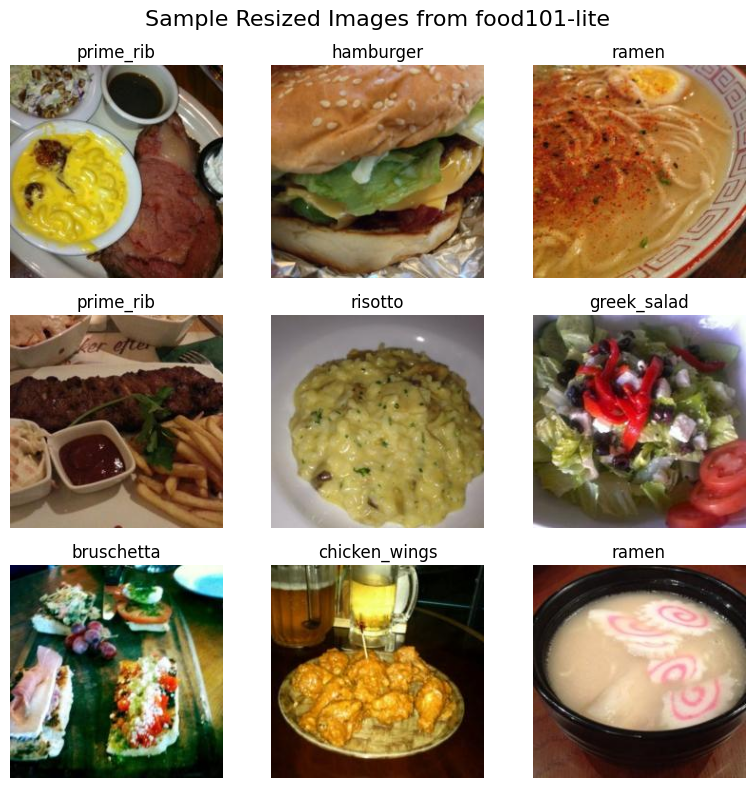

In [5]:
# 04. Visualize the dataset

label_names = ds.features["label"].names  # maps int → string

samples = random.sample(records, 9)

fig, axs = plt.subplots(3, 3, figsize=(8, 8))
fig.suptitle("Sample Resized Images from food101-lite", fontsize=16)

for ax, rec in zip(axs.flatten(), samples):
    img = Image.open(io.BytesIO(rec["image_bytes"]))
    label_name = label_names[rec["label"]]
    ax.imshow(img)
    ax.set_title(label_name)
    ax.axis("off")

plt.tight_layout()
plt.show()

## 5. Persist to Parquet  
Write the images and labels to a Parquet file. Because Parquet is columnar, you can read just the columns you need during training, which speeds up IO—especially when multiple workers are reading in parallel under Ray.

In [6]:
# 05. Write Dataset to Parquet

output_dir = "/mnt/cluster_storage/food101_lite/parquet_256"
os.makedirs(output_dir, exist_ok=True)

table = pa.Table.from_pydict({
    "image_bytes": [r["image_bytes"] for r in records],
    "label": [r["label"] for r in records]
})
pq.write_table(table, os.path.join(output_dir, "shard_0.parquet"))

print(f"Wrote {len(records)} records to {output_dir}")

Wrote 7575 records to /mnt/cluster_storage/food101_lite/parquet_256


## 6. Custom `Food101Dataset` for Parquet  
To feed data into PyTorch, define a custom `Dataset`. You cache Parquet metadata, map global indices to specific row groups, and pull only the row you need. Each `__getitem__` returns an `(image, label)` pair that's immediately ready for further transforms.

In [7]:
# 06. Define PyTorch Dataset that loads from Parquet

class Food101Dataset(Dataset):
    def __init__(self, parquet_path: str, transform=None):
        self.parquet_file = pq.ParquetFile(parquet_path)
        self.transform = transform

        # Precompute a global row index to (row_group_idx, local_idx) map
        self.row_group_map = []
        for rg_idx in range(self.parquet_file.num_row_groups):
            rg_meta = self.parquet_file.metadata.row_group(rg_idx)
            num_rows = rg_meta.num_rows
            self.row_group_map.extend([(rg_idx, i) for i in range(num_rows)])

    def __len__(self):
        return len(self.row_group_map)

    def __getitem__(self, idx):
        row_group_idx, local_idx = self.row_group_map[idx]
        # Read only the relevant row group (in memory-efficient batch---for scalability)
        table = self.parquet_file.read_row_group(row_group_idx, columns=["image_bytes", "label"])
        row = table.to_pandas().iloc[local_idx]

        img = Image.open(io.BytesIO(row["image_bytes"])).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, row["label"]

## 7. Image transform  
Create a transform pipeline: `ToTensor()` followed by ImageNet mean and standard-deviation normalisation. By applying the transform inside the dataset, you make sure every worker, no matter where it runs, processes images in exactly the same way.

In [8]:
# 07. Define data preprocessing transform
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

## 8. Train/validation split  
Shuffle the full Parquet table once (seeded for reproducibility) and then slice off the last 500 rows to construct the validation set. Write the train and validation partitions to their own Parquet files so you can load them independently later.

In [9]:
# 08. Create train/val Parquet splits 
full_path = "/mnt/cluster_storage/food101_lite/parquet_256/shard_0.parquet"

df = (
    pq.read_table(full_path)
    .to_pandas()
    .sample(frac=1.0, random_state=42)  # shuffle for reproducibility
)

df[:-500].to_parquet("/mnt/cluster_storage/food101_lite/train.parquet")   # training
df[-500:].to_parquet("/mnt/cluster_storage/food101_lite/val.parquet")     # validation

## 9. Inspect a DataLoader batch  
Before you scale out, build a regular single-process `DataLoader`, pull one batch, and print its shape. This tiny test reassures you that batching, multiprocessing, and transforms work correctly.

In [10]:
# 09. Observe data shape

loader = DataLoader(
    Food101Dataset("/mnt/cluster_storage/food101_lite/train.parquet", transform=transform),
    batch_size=16,
    shuffle=True,
    num_workers=4,
)

for images, labels in loader:
    print(images.shape, labels.shape)
    break

torch.Size([16, 3, 224, 224]) torch.Size([16])


## 10. Helper: Ray-prepared DataLoaders  
Wrap the DataLoader with `prepare_data_loader`. Ray injects a `DistributedSampler`, pins the loader to the correct GPU, and handles worker-rank bookkeeping. With this helper, your training loop can be isolated from distributed details.

In [11]:
# 10. Define helper to create prepared DataLoader
from torch.utils.data.distributed import DistributedSampler

def build_dataloader(parquet_path: str, batch_size: int, shuffle=True):
    dataset = Food101Dataset(parquet_path, transform=transform)

    # Add a DistributedSampler to shard data across workers
    sampler = DistributedSampler(
        dataset,
        num_replicas=train.get_context().get_world_size(),
        rank=train.get_context().get_world_rank(),
        shuffle=shuffle,
        drop_last=shuffle,
    )

    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        sampler=sampler,
        num_workers=2,
    )
    return prepare_data_loader(loader)

## 11. `train_loop_per_worker`  
This is the workhorse called by each Ray worker. Inside, build the model, optimizer, and loss, try to resume from any existing checkpoint, run the training and validation loops, log metrics, and (on rank 0) save new checkpoints and append results to a history file. At the end, compute a final validation accuracy for good measure.

In [12]:
# 11. Define Ray Train train_loop_per_worker
def train_loop_per_worker(config):

    # === Model ===
    net = resnet18(num_classes=101)
    model = prepare_model(net)

    # === Optimizer / Loss ===
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    criterion = nn.CrossEntropyLoss()

    # === Resume from Checkpoint ===
    checkpoint = get_checkpoint()
    start_epoch = 0
    if checkpoint:
        with checkpoint.as_directory() as ckpt_dir:
            model.load_state_dict(torch.load(os.path.join(ckpt_dir, "model.pt")))
            optimizer.load_state_dict(torch.load(os.path.join(ckpt_dir, "optimizer.pt")))
            start_epoch = torch.load(os.path.join(ckpt_dir, "extra.pt"))["epoch"]
        print(f"[Rank {get_context().get_world_rank()}] Resumed from checkpoint at epoch {start_epoch}")

    # === DataLoaders ===
    train_loader = build_dataloader(
        "/mnt/cluster_storage/food101_lite/train.parquet", config["batch_size"], shuffle=True
    )
    val_loader = build_dataloader(
        "/mnt/cluster_storage/food101_lite/val.parquet", config["batch_size"], shuffle=False
    )

    # === Training Loop ===
    for epoch in range(start_epoch, config["epochs"]):
        train_loader.sampler.set_epoch(epoch)  # required when using DistributedSampler
        model.train()
        train_loss_total = 0.0
        train_batches = 0

        for xb, yb in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()
            train_loss_total += loss.item()
            train_batches += 1

        train_loss = train_loss_total / train_batches

        # === Validation Loop ===
        model.eval()
        val_loss_total = 0.0
        val_batches = 0
        with torch.no_grad():
            for val_xb, val_yb in val_loader:
                val_loss_total += criterion(model(val_xb), val_yb).item()
                val_batches += 1
        val_loss = val_loss_total / val_batches

        metrics = {"train_loss": train_loss, "val_loss": val_loss, "epoch": epoch}
        if train.get_context().get_world_rank() == 0:
            print(metrics)

        # === Save checkpoint only on rank 0 ===
        if get_context().get_world_rank() == 0:
            ckpt_dir = f"/mnt/cluster_storage/food101_lite/tmp_checkpoints/epoch_{epoch}_{uuid.uuid4().hex}"
            os.makedirs(ckpt_dir, exist_ok=True)
            torch.save(model.state_dict(), os.path.join(ckpt_dir, "model.pt"))
            torch.save(optimizer.state_dict(), os.path.join(ckpt_dir, "optimizer.pt"))
            torch.save({"epoch": epoch}, os.path.join(ckpt_dir, "extra.pt"))
            checkpoint = Checkpoint.from_directory(ckpt_dir)
        else:
            checkpoint = None

        # Append metrics to a file (only on rank 0)
        if train.get_context().get_world_rank() == 0:
            with open("/mnt/cluster_storage/food101_lite/results/history.csv", "a") as f:
                f.write(f"{epoch},{train_loss},{val_loss}\n")
        train.report(metrics, checkpoint=checkpoint)

    correct, total = 0, 0
    model.eval()
    for xb, yb in val_loader:
        xb, yb = xb.cuda(), yb.cuda()
        pred = model(xb).argmax(dim=1)
        correct += (pred == yb).sum().item()
        total += yb.size(0)
    accuracy = correct / total
    print(f"Val Accuracy: {accuracy:.2%}")

## 12. Launch distributed training with `TorchTrainer`  
Instantiate a `TorchTrainer`. Ask for eight GPU workers, enable up to three automatic retries, and tell Ray to keep the five checkpoints with the lowest validation loss. One call to `trainer.fit()` kicks off a fault-tolerant job on your Anyscale cluster.

In [13]:
# 12. Run Training with Ray Train 

trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config={"lr": 1e-3, "batch_size": 64, "epochs": 10},
    scaling_config=ScalingConfig(num_workers=8, use_gpu=True),
    run_config=RunConfig(
        name="food101_ft_resume",
        storage_path="/mnt/cluster_storage/food101_lite/results",
        checkpoint_config=CheckpointConfig(
            num_to_keep=5, 
            checkpoint_frequency=1,
            checkpoint_score_attribute="val_loss",
            checkpoint_score_order="min"
        ),
        failure_config=FailureConfig(max_failures=3),
    ),
)

result = trainer.fit()
print("Final metrics:", result.metrics)
best_ckpt = result.checkpoint  # this is the one with lowest val_loss

2025-09-29 08:05:15,959	INFO worker.py:1747 -- Connecting to existing Ray cluster at address: 10.0.82.26:6379...
2025-09-29 08:05:15,970	INFO worker.py:1918 -- Connected to Ray cluster. View the dashboard at https://session-qeldn6zjudjryzt3wypjak8arr.i.anyscaleuserdata.com 
2025-09-29 08:05:15,975	INFO packaging.py:380 -- Pushing file package 'gcs://_ray_pkg_b767fe0d351f1aff332796194c636f2fca525194.zip' (1.07MiB) to Ray cluster...
2025-09-29 08:05:15,978	INFO packaging.py:393 -- Successfully pushed file package 'gcs://_ray_pkg_b767fe0d351f1aff332796194c636f2fca525194.zip'.
(TrainController pid=26713) [State Transition] INITIALIZING -> SCHEDULING.
(TrainController pid=26713) Attempting to start training worker group of size 8 with the following resources: [{'GPU': 1}] * 8
(TrainController pid=26713) Using blocking ray.get inside async actor. This blocks the event loop. Please use `await` on object ref with asyncio.gather if you want to yield execution to the event loop instead.
(TrainCo

Final metrics: {'train_loss': 0.9398999171597617, 'val_loss': 1.6351689100265503, 'epoch': 9}


## 13. Plot loss curves  
When training finishes, read the CSV history file and plot training and validation losses for every epoch. Seeing the two curves together helps you spot over-fitting or under-fitting at a glance. In this example, given enough epochs, it's expected to see some over-fitting, as indicated by the decrease in training loss but increase in validation loss. As you're saving the checkpoints of the model with the lowest validation curve, you can test inference prior to this phenomenon. 

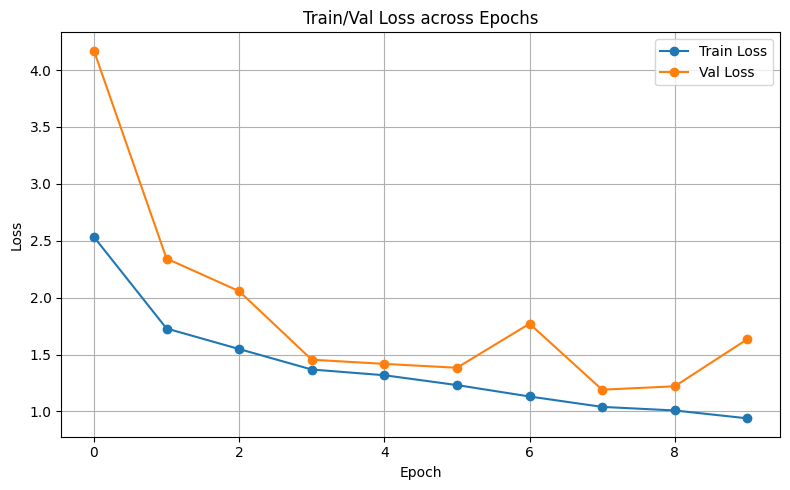

In [14]:
# 13. Plot training / validation loss curves
history_path = "/mnt/cluster_storage/food101_lite/results/history.csv"
df = pd.read_csv(history_path, names=["epoch", "train_loss", "val_loss"])

# Plot
plt.figure(figsize=(8, 5))
plt.plot(df["epoch"], df["train_loss"], label="Train Loss", marker="o")
plt.plot(df["epoch"], df["val_loss"], label="Val Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train/Val Loss across Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## 14. Demonstrate fault-tolerant resumption  
To prove that checkpointing works, run `trainer.fit()` a second time without changing anything. If the earlier run crashed mid-epoch, Ray automatically picks up the latest checkpoint and continue. If it already finished, Ray simply starts a clean new experiment.

In [15]:
# 14. Run the trainer again to demonstrate resuming from latest checkpoint  

result = trainer.fit()
print("Final metrics:", result.metrics)

(TrainController pid=30100) A run snapshot was found in storage folder at: '/mnt/cluster_storage/food101_lite/results/food101_ft_resume'
(TrainController pid=30100) This snapshot contains a list of checkpoints reported via `ray.train.report` and will be loaded. This allows the latest checkpoint found in the snapshot to be accessible within your training function via `ray.train.get_checkpoint`.
(TrainController pid=30100) If you meant to start a brand new training job without any information about previous checkpoints found in this directory, please configure a new, unique `RunConfig(name)` or delete the existing folder at '/mnt/cluster_storage/food101_lite/results/food101_ft_resume'.
(TrainController pid=30100) [State Transition] INITIALIZING -> SCHEDULING.
(TrainController pid=30100) Attempting to start training worker group of size 8 with the following resources: [{'GPU': 1}] * 8
(TrainController pid=30100) Using blocking ray.get inside async actor. This blocks the event loop. Please

Final metrics: {'train_loss': 0.8341124313218253, 'val_loss': 1.5722384452819824, 'epoch': 9}


## 15. Remote inference helper  
Define a lightweight Ray remote function that loads a chosen checkpoint into a fresh `resnet18`, runs inference on one image, and returns both the predicted and true labels. Because the function requests one GPU, Ray schedules it on an appropriate node.

In [16]:

# 15. Define batch inference function

@ray.remote(num_gpus=1)
def run_inference_from_checkpoint(checkpoint_path, parquet_path, idx=0):

    # === Load model ===
    model = resnet18(num_classes=101)
    checkpoint = Checkpoint.from_directory(checkpoint_path)

    with checkpoint.as_directory() as ckpt_dir:
        state_dict = torch.load(os.path.join(ckpt_dir, "model.pt"), map_location="cuda")

        # Strip "module." prefix from distributed data parallelism trained weights
        state_dict = {k.replace("module.", "", 1): v for k, v in state_dict.items()}

        model.load_state_dict(state_dict)

    model.eval().cuda()

    # === Define transform ===
    transform = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ])

    # === Load dataset ===
    dataset = Food101Dataset(parquet_path, transform=transform)
    img, label = dataset[idx]
    img = img.unsqueeze(0).cuda()  # batch size 1

    with torch.no_grad():
        logits = model(img)
        pred = torch.argmax(logits, dim=1).item()

    return {"predicted_label": pred, "true_label": int(label), "index": idx}

## 16. Run and visualize inference  
Using the checkpoint with the lowest validation loss, invoke your remote inference helper on a validation image. Then plot the image while displaying both the model’s prediction and the ground-truth class, giving you an immediate, intuitive sense of performance.

Best checkpoint contents: ['extra.pt', 'optimizer.pt', 'model.pt']
{'predicted_label': 79, 'true_label': 79, 'index': 2}


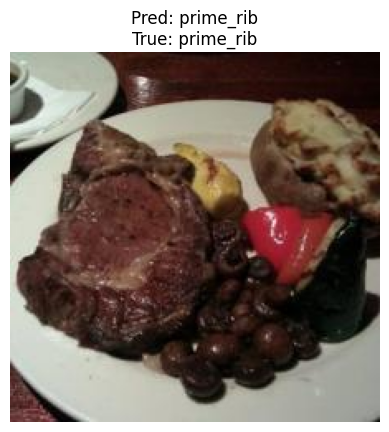

In [ ]:
# 16. Perform inference with best trained model (that is, lowest validation loss for a checkpointed model)
 
checkpoint_root = "/mnt/cluster_storage/food101_lite/results/food101_ft_resume"

checkpoint_dirs = sorted(
    [
        d for d in os.listdir(checkpoint_root)
        if d.startswith("checkpoint_") and os.path.isdir(os.path.join(checkpoint_root, d))
    ],
    reverse=True,
)

if not checkpoint_dirs:
    raise FileNotFoundError("No checkpoint directories found.")

with result.checkpoint.as_directory() as ckpt_dir:
    print("Best checkpoint contents:", os.listdir(ckpt_dir))
    best_ckpt_path = ckpt_dir 
parquet_path = "/mnt/cluster_storage/food101_lite/val.parquet"

# Define which image to use
idx = 2

# Launch GPU inference task with Ray
result = ray.get(run_inference_from_checkpoint.remote(best_ckpt_path, parquet_path, idx=idx))
print(result)

# Load label map from Hugging Face
ds = load_dataset("food101", split="train[:1%]")  # load just to get label names
label_names = ds.features["label"].names

# Load image from the same dataset locally
dataset = Food101Dataset(parquet_path, transform=None)  # No transform = raw image
img, _ = dataset[idx]

# Plot the image with predicted and true labels
plt.imshow(img)
plt.axis("off")
plt.title(f"Pred: {label_names[result['predicted_label']]}\nTrue: {label_names[result['true_label']]}")
plt.show()

## 17. Clean up  
Finally, tidy up by deleting temporary checkpoint folders, the metrics CSV, and any intermediate result directories. Clearing out old artifacts frees disk space and leaves your workspace clean for whatever comes next.

In [18]:
# 17. Cleanup---delete checkpoints and metrics from model training

# Base directory
BASE_DIR = "/mnt/cluster_storage/food101_lite"

# Paths to clean
paths_to_delete = [
    os.path.join(BASE_DIR, "tmp_checkpoints"),           # custom checkpoints
    os.path.join(BASE_DIR, "results", "history.csv"),    # metrics history file
    os.path.join(BASE_DIR, "results", "food101_ft_resume"),  # ray trainer run dir
    os.path.join(BASE_DIR, "results", "food101_ft_run"),
    os.path.join(BASE_DIR, "results", "food101_single_run"),
]

# Delete each path if it exists
for path in paths_to_delete:
    if os.path.exists(path):
        if os.path.isfile(path):
            os.remove(path)
            print(f"Deleted file: {path}")
        else:
            shutil.rmtree(path)
            print(f"Deleted directory: {path}")
    else:
        print(f"Not found (skipped): {path}")

Deleted directory: /mnt/cluster_storage/food101_lite/tmp_checkpoints
Deleted file: /mnt/cluster_storage/food101_lite/results/history.csv
Deleted directory: /mnt/cluster_storage/food101_lite/results/food101_ft_resume
Not found (skipped): /mnt/cluster_storage/food101_lite/results/food101_ft_run
Not found (skipped): /mnt/cluster_storage/food101_lite/results/food101_single_run


(raylet) WARNING: 4 PYTHON worker processes have been started on node: 9cb171e30a8b8e86a2c30d2b4a698d4e94f31d29ee391a083db570e1 with address: 10.0.82.26. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
(raylet) WARNING: 6 PYTHON worker processes have been started on node: 9cb171e30a8b8e86a2c30d2b4a698d4e94f31d29ee391a083db570e1 with address: 10.0.82.26. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).


## Wrap up and next steps

You've taken a realistic computer-vision workload, from raw images all the way to distributed training and GPU inference, and run it on Ray Train with zero boilerplate around GPUs, data parallelism, or fault-tolerance. You should now feel comfortable:

* Using **Ray Train’s TorchTrainer** to scale PyTorch training across multiple GPUs and nodes with minimal code changes  
* Wrapping models and data loaders with **`prepare_model()`** and **`prepare_data_loader()`** to enable Ray-managed device placement and distributed execution  
* Sharding data across workers using **`DistributedSampler`**, and coordinating training epochs across Ray workers  
* Configuring **automatic checkpointing and failure recovery** using Ray Train’s built-in `Checkpoint`, `RunConfig`, and `FailureConfig` APIs  
* Running **GPU-backed Ray tasks** for distributed inference, showing how to serve and scale model predictions across a Ray cluster  

---

### Where can you take this next?

Below are a few directions you might explore to adapt or extend the pattern:

1. **Larger or custom datasets**  
   * Swap in the full 75 k-image Food-101 split—or your own dataset in any storage backend (S3, GCS, Azure Blob).  
   * Add multi-file Parquet sharding and let each worker read a different shard.

2. **Model architectures**  
   * Drop in Vision Transformers (`vit_b_16`, `vit_l_32`) or ConvNeXt; the prepare helpers work exactly the same.  
   * Experiment with transfer learning versus training from scratch.

3. **Mixed precision and performance tuning**  
   * Enable automatic mixed precision (`torch.cuda.amp`) or bfloat16 to speed up training and save memory.  
   * Profile data-loading throughput and play with `num_workers`, prefetching, and caching.

4. **Hyperparameter sweeps**  
   * Wrap the training loop in **Ray Tune** to search over learning rates, augmentations, or optimizers.  
   * Use Ray’s integrated reporting to schedule early stopping.

5. **Data augmentation pipelines**  
   * Integrate additional transforms inside the dataset class for image augmentation.  
   * Compare CPU versus GPU-side augmentations for throughput.

6. **Distributed validation and metrics**  
   * Replace your simple accuracy printout with more advanced metrics (F1, top-5 accuracy, confusion matrices).  

7. **Model serving**  
   * Convert the remote inference helper into a **Ray Serve** deployment for low-latency online predictions.  
   * Auto-scale replicas based on request volume.

8. **End-to-end MLOps**  
   * Register checkpoints in a model registry (for example, MLflow, Weights & Biases, or Ray’s built-in MLflow integration).  
   * Schedule the notebook as a Ray Job or CI/CD pipeline for regular retraining runs.
